In [4]:
from pyspark.sql.types import *
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

import seaborn as sns

sc = SparkContext('local')
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/28 17:28:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.load('/Users/olenapleshan/data_analytics/ca3/MiningProcess_Flotation_Plant_Database.csv',  format="csv", header="true", sep=',')
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- % Iron Feed: string (nullable = true)
 |-- % Silica Feed: string (nullable = true)
 |-- Starch Flow: string (nullable = true)
 |-- Amina Flow: string (nullable = true)
 |-- Ore Pulp Flow: string (nullable = true)
 |-- Ore Pulp pH: string (nullable = true)
 |-- Ore Pulp Density: string (nullable = true)
 |-- Flotation Column 01 Air Flow: string (nullable = true)
 |-- Flotation Column 02 Air Flow: string (nullable = true)
 |-- Flotation Column 03 Air Flow: string (nullable = true)
 |-- Flotation Column 04 Air Flow: string (nullable = true)
 |-- Flotation Column 05 Air Flow: string (nullable = true)
 |-- Flotation Column 06 Air Flow: string (nullable = true)
 |-- Flotation Column 07 Air Flow: string (nullable = true)
 |-- Flotation Column 01 Level: string (nullable = true)
 |-- Flotation Column 02 Level: string (nullable = true)
 |-- Flotation Column 03 Level: string (nullable = true)
 |-- Flotation Column 04 Level: string (nullable = true)
 |

In [2]:
#Create first network with Keras
import numpy
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPool2D, Flatten, Conv1D

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score

2024-09-28 17:27:20.481072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

dataset = df.toPandas()
dataset = dataset.dropna()
dataset.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


In [7]:
dataset = dataset.rename(columns={c: c.lower().replace(" ", "_").replace("%", "pct") for c in dataset.columns})

In [8]:
dataset.dtypes

date                            object
pct_iron_feed                   object
pct_silica_feed                 object
starch_flow                     object
amina_flow                      object
ore_pulp_flow                   object
ore_pulp_ph                     object
ore_pulp_density                object
flotation_column_01_air_flow    object
flotation_column_02_air_flow    object
flotation_column_03_air_flow    object
flotation_column_04_air_flow    object
flotation_column_05_air_flow    object
flotation_column_06_air_flow    object
flotation_column_07_air_flow    object
flotation_column_01_level       object
flotation_column_02_level       object
flotation_column_03_level       object
flotation_column_04_level       object
flotation_column_05_level       object
flotation_column_06_level       object
flotation_column_07_level       object
pct_iron_concentrate            object
pct_silica_concentrate          object
dtype: object

In [9]:
dataset.columns

Index(['date', 'pct_iron_feed', 'pct_silica_feed', 'starch_flow', 'amina_flow',
       'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
       'flotation_column_01_air_flow', 'flotation_column_02_air_flow',
       'flotation_column_03_air_flow', 'flotation_column_04_air_flow',
       'flotation_column_05_air_flow', 'flotation_column_06_air_flow',
       'flotation_column_07_air_flow', 'flotation_column_01_level',
       'flotation_column_02_level', 'flotation_column_03_level',
       'flotation_column_04_level', 'flotation_column_05_level',
       'flotation_column_06_level', 'flotation_column_07_level',
       'pct_iron_concentrate', 'pct_silica_concentrate'],
      dtype='object')

In [10]:
dataset = dataset.replace(",", ".", regex=True)
dataset.head()

,date,pct_iron_feed,pct_silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,flotation_column_01_air_flow,flotation_column_02_air_flow,...,flotation_column_07_air_flow,flotation_column_01_level,flotation_column_02_level,flotation_column_03_level,flotation_column_04_level,flotation_column_05_level,flotation_column_06_level,flotation_column_07_level,pct_iron_concentrate,pct_silica_concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.37,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.56,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.068,1.74,249.741,247.874,...,248.071,451.24,468.927,434.61,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.21,471.411,437.69,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.9,450.523,453.67,462.598,443.682,425.679,66.91,1.31


In [11]:
dataset = dataset.sample(n=1000)

In [12]:
dataset.head()

,date,pct_iron_feed,pct_silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,flotation_column_01_air_flow,flotation_column_02_air_flow,...,flotation_column_07_air_flow,flotation_column_01_level,flotation_column_02_level,flotation_column_03_level,flotation_column_04_level,flotation_column_05_level,flotation_column_06_level,flotation_column_07_level,pct_iron_concentrate,pct_silica_concentrate
444267,2017-07-04 03:00:00,55.69,15.18,3107.5,540.543,398.895,9.99106,1.65575,299.844,298.924,...,309.484,395.888,355.916,394.007,402.418,389.953,396.66,422.302,66.59,1.3
83192,2017-04-11 13:00:00,56.57,13.47,567.6893757347,297.4999835637,379.7686696074,9.16016,1.5283025453,251.23,250.366,...,249.282,849.2726374269,803.9756512907,871.2187827715,581.8115886814,651.614875,432.8983990768,627.6584699215,65.28,1.68
603596,2017-08-10 00:00:00,48.81,25.31,2453.13,386.148,379.2064,9.52873,1.68218,301.004,299.224,...,301.202,514.477,509.199,595.664,365.836,224.1315555556,336.817,333.813,64.57,1.41
231907,2017-05-15 23:00:00,64.03,6.26,3549.5,410.189,404.953,9.41275,1.63292,250.868,249.936,...,302.985,442.77,455.697,171.4955851852,375.094,310.657,344.617,347.861,63.89,1.82
272770,2017-05-25 10:00:00,64.03,6.26,3332.93,361.434,403.043,9.11037,1.5199717544,299.172,246.393,...,302.296,448.92,436.956,470.758,339.934,351.777,348.93,360.349,65.62,1.21


In [13]:
# split into input (X ie dependent variables) and output (Y ie independent variables) variables

X = dataset.iloc[:,1:23]   # drop the date, columns 1-22 are independent variables
Y = dataset.iloc[:,23] # % Silica Concentrate

In [14]:
X.shape
Y = Y.astype(float)
X = X.astype(float)

<Axes: xlabel='pct_silica_concentrate', ylabel='Count'>

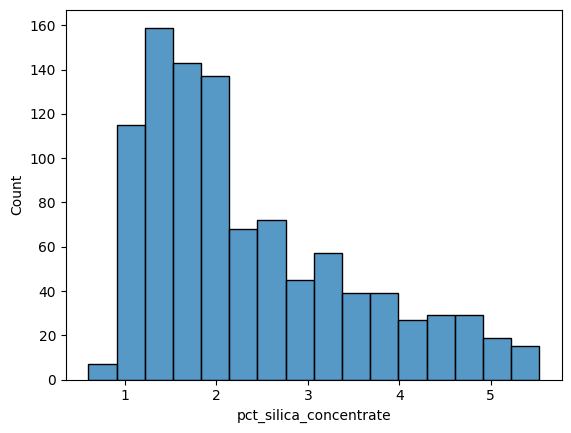

In [17]:
sns.histplot(Y)

In [19]:
Y

444267    1.30
83192     1.68
603596    1.41
231907    1.82
272770    1.21
          ... 
350260    1.82
233383    1.14
452104    1.43
258349    0.85
10230     2.99
Name: pct_silica_concentrate, Length: 1000, dtype: float64

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
# create model
model = Sequential()
model.add(Dense(500, input_dim=X.shape[1], activation='sigmoid')) # 500 neurons
model.add(Dense(1)) # 1 output neuron

model.compile(loss='mean_squared_error', optimizer='adagrad', metrics=[keras.metrics.RootMeanSquaredError(), 
                                keras.metrics.MeanAbsoluteError(),
                                keras.metrics.Accuracy()])


In [21]:
# Compile model
h = model.fit(X, Y, epochs=50, batch_size=20,  verbose=2) # 150 epoch, 10 batch size, verbose = 2

Epoch 1/50
50/50 - 1s - loss: 1.6515 - root_mean_squared_error: 1.2851 - mean_absolute_error: 0.9550 - accuracy: 0.0000e+00 - 785ms/epoch - 16ms/step
Epoch 2/50
50/50 - 0s - loss: 1.1919 - root_mean_squared_error: 1.0917 - mean_absolute_error: 0.8822 - accuracy: 0.0000e+00 - 80ms/epoch - 2ms/step
Epoch 3/50
50/50 - 0s - loss: 1.1275 - root_mean_squared_error: 1.0618 - mean_absolute_error: 0.8633 - accuracy: 0.0000e+00 - 81ms/epoch - 2ms/step
Epoch 4/50
50/50 - 0s - loss: 1.0778 - root_mean_squared_error: 1.0382 - mean_absolute_error: 0.8418 - accuracy: 0.0000e+00 - 76ms/epoch - 2ms/step
Epoch 5/50
50/50 - 0s - loss: 1.0361 - root_mean_squared_error: 1.0179 - mean_absolute_error: 0.8234 - accuracy: 0.0000e+00 - 75ms/epoch - 1ms/step
Epoch 6/50
50/50 - 0s - loss: 0.9995 - root_mean_squared_error: 0.9997 - mean_absolute_error: 0.8092 - accuracy: 0.0000e+00 - 76ms/epoch - 2ms/step
Epoch 7/50
50/50 - 0s - loss: 0.9687 - root_mean_squared_error: 0.9842 - mean_absolute_error: 0.7885 - accurac

### Plotting metrics
In Keras, “loss” refers to the training loss, indicating how well the model is performing on the training data, while “val_loss” is the validation loss, representing the model's performance on a separate validation dataset, providing insights into generalization performance.

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_metrics(history):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    #Add traces
    for k, v in history.history.items():
        fig.add_trace(
            go.Scatter( y=v, name=k),
            secondary_y=False,
        )

    # Add figure title
    fig.update_layout(
        title_text="Metrics of Model"
    )
    
    # Set x-axis title
    fig.update_xaxes(title_text="Epoch")
    # Set y-axes titles
    fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
    fig.update_yaxes(title_text="<b>secondary</b> MAE", secondary_y=True)
    
    fig.show()

In [23]:
plot_metrics(h)

In [24]:
# evaluate the model
scores = model.evaluate(X, Y)
print(scores)

predictions = model.predict(X)    # predicting Y only using X


 1/32 [..............................] - ETA: 7s - loss: 0.5897 - root_mean_squared_error: 0.7679 - mean_absolute_error: 0.6362 - accuracy: 0.0000e+00

32/32 [==============================] - 0s 6ms/step - loss: 0.5685 - root_mean_squared_error: 0.7540 - mean_absolute_error: 0.5812 - accuracy: 0.0000e+00
[0.568483293056488, 0.7539783120155334, 0.5811648964881897, 0.0]
32/32 [==============================] - 0s 2ms/step


In [25]:
# calculate predictions
predictions = model.predict(X)    # predicting Y only using X

32/32 [==============================] - 0s 1ms/step


In [26]:
# Round predictions
#rounded = [int(numpy.round(x, 0)) for x in predictions]
rounded = [round(x[0]) for x in predictions]
print(rounded)

[2, 2, 3, 3, 2, 2, 3, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 3, 4, 2, 3, 3, 3, 1, 3, 3, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 3, 1, 4, 3, 2, 1, 3, 4, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 4, 2, 2, 2, 3, 1, 4, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 2, 2, 2, 3, 3, 2, 3, 3, 3, 4, 2, 2, 2, 3, 2, 2, 4, 1, 2, 3, 2, 2, 2, 2, 4, 1, 3, 2, 3, 2, 2, 2, 4, 2, 2, 2, 3, 3, 2, 2, 3, 4, 3, 2, 2, 2, 2, 2, 2, 3, 4, 2, 3, 2, 3, 2, 1, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 1, 3, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 4, 2, 1, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 3, 1, 3, 2, 4, 3, 2, 3, 2, 2, 3, 1, 2, 3, 2, 1, 3, 1, 2, 2, 1, 2, 3, 2, 2, 3, 3, 4, 2, 3, 2, 1, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 4, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 1, 2, 4, 2, 3, 2, 2, 2, 2, 4, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1, 1, 2, 3, 3, 4, 2, 3, 2, 2, 2, 3, 3, 3, 1, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 

In [27]:
# FOR CLASSIFICATION
# import matplotlib.pyplot as plt
# import numpy
# from sklearn import metrics

# actual = Y
# predicted = rounded

# confusion_matrix = metrics.confusion_matrix(actual, predicted)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# cm_display.plot()
# plt.show() 

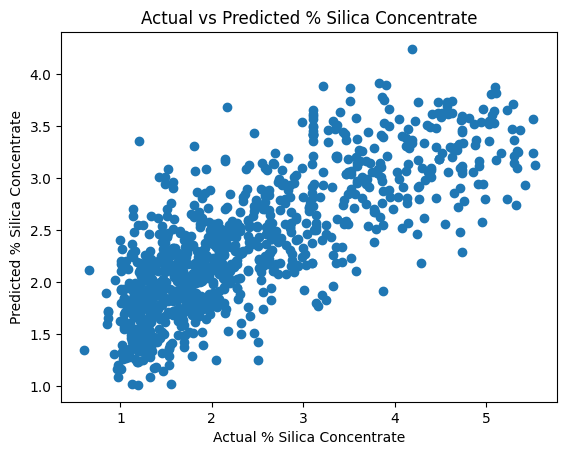

In [28]:
plt.scatter(Y, predictions)
plt.xlabel('Actual % Silica Concentrate')
plt.ylabel('Predicted % Silica Concentrate')
plt.title('Actual vs Predicted % Silica Concentrate')
plt.show()

A residual is a measure of how far away a point is vertically from the regression line. Simply, it is the error between a predicted value and the observed actual value.

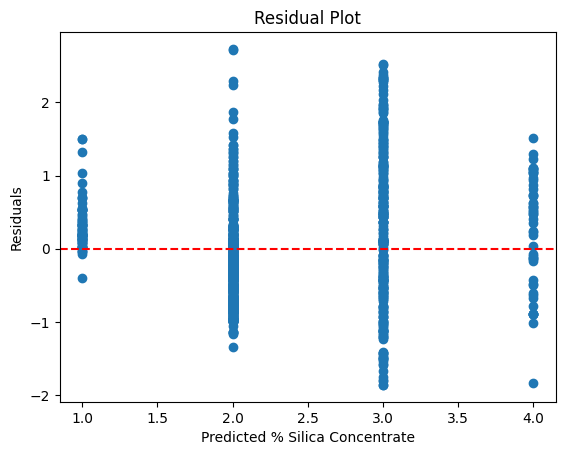

In [29]:
residuals = Y - rounded
plt.scatter(rounded, residuals)
plt.xlabel('Predicted % Silica Concentrate')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Prepare for experimentation

# ANN
Artificial Neural Network 

Selected evaluation metrics:

**RMSE**
The root mean square error (RMSE) measures the average difference between a statistical model's predicted values and the actual values. Mathematically, it is the standard deviation of the residuals. Residuals represent the distance between the regression line and the data points.

**MAE**
mean absolute error is a measure of errors between paired observations expressing the same phenomenon.

https://keras.io/api/losses/regression_losses/

In [22]:

def build_ann(exp):
    model = Sequential()
    # Dense: fully connected layer in a sequential mode
    # implementation of the equation output = activation(dot(input, kernel) + bias)
    model.add(Dense(exp.dense_units,        # number of neurons
                     input_dim=exp.x.shape[1], 
                     activation=exp.activation))
     
    model.add(Dense(1))                      # 1 output neuron
     
    model.compile(loss=exp.loss, 
                   optimizer=exp.optimizer,
                   metrics=[keras.metrics.RootMeanSquaredError(), 
                            keras.metrics.MeanAbsoluteError(),
                            keras.metrics.Accuracy()])
    
    return model

def fit_and_predict(exp, model):
    return (model.fit(exp.x, 
                        exp.y, 
                        validation_split=exp.validation_split, 
                        epochs=exp.epocs, 
                        batch_size=20,  
                        verbose=0), 
            model.predict(exp.x))

def plot_prediction(exp, predictions):
    plt.scatter(exp.y, predictions)
    plt.xlabel('Actual % Silica Concentrate')
    plt.ylabel('Predicted % Silica Concentrate')
    plt.title(f'Activation func: {exp.activation}, optimizer: {exp.optimizer}, dense units: {exp.dense_units}, epocs: {exp.epocs}')
    plt.show()

In [23]:
class Experiment:
    x=X
    y=Y

    dense_units=500
    epocs=50
    validation_split=0.2
    activation='sigmoid'
    loss='mean_squared_error'
    optimizer='adagrad'

    def __init__(self):
        pass


32/32 [==============================] - 0s 3ms/step


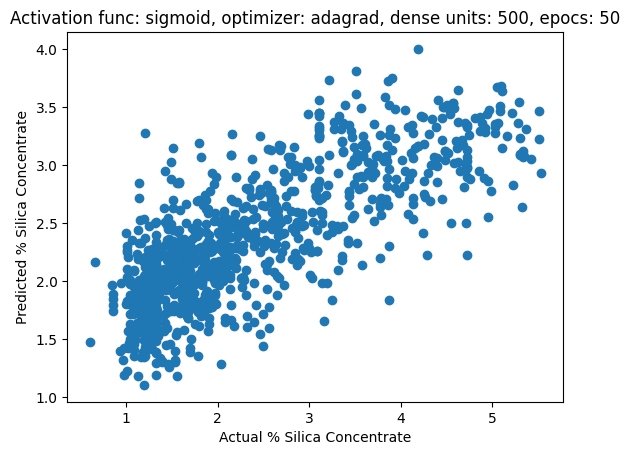

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 500)               11500     
                                                                 
 dense_3 (Dense)             (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.6223 - root_mean_squared_error: 0.7889 - mean_absolute_error: 0.6138 - accuracy: 0.0000e+00


In [32]:
# create model
exp1 = Experiment()
exp1.ann_model = build_ann(exp1)

# ------------------- #
exp1.ann_history, exp1.ann_prediction = fit_and_predict(exp1, exp1.ann_model)
plot_prediction(exp1, exp1.ann_prediction)

exp1.ann_model.summary(),
exp1.ann_model.evaluate(X, Y)

plot_metrics(exp1.ann_history)


## Experiments with Activation Functions

32/32 [==============================] - 0s 2ms/step


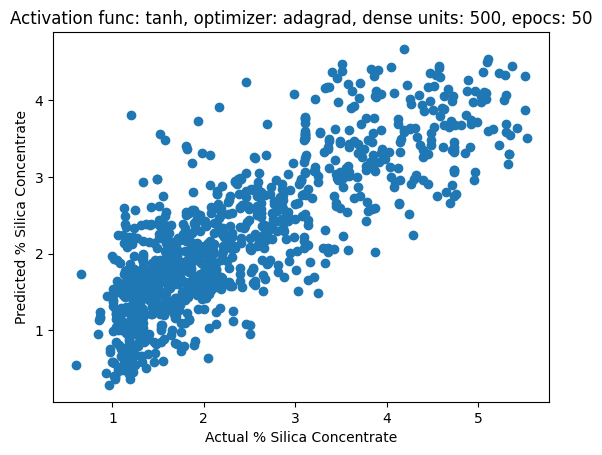

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 500)               11500     
                                                                 
 dense_5 (Dense)             (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 2ms/step - loss: 0.4525 - root_mean_squared_error: 0.6727 - mean_absolute_error: 0.5144 - accuracy: 0.0000e+00


In [33]:
exp2 = Experiment()
exp2.activation='tanh'

# ------------------- #
exp2.ann_model = build_ann(exp2)
exp2.ann_history, exp2.ann_prediction = fit_and_predict(exp2, exp2.ann_model)
plot_prediction(exp2, exp2.ann_prediction)

exp2.ann_model.summary(),
exp2.ann_model.evaluate(X, Y)

plot_metrics(exp2.ann_history)


### Experiment 3: Sigmoid activation function

32/32 [==============================] - 0s 3ms/step


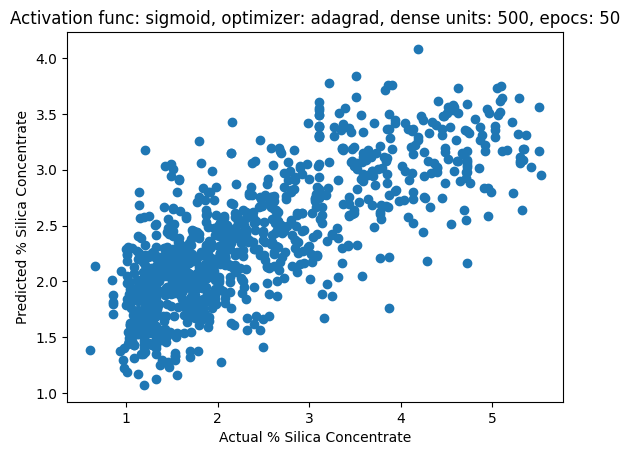

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 500)               11500     
                                                                 
 dense_7 (Dense)             (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.6195 - root_mean_squared_error: 0.7871 - mean_absolute_error: 0.6142 - accuracy: 0.0000e+00


In [34]:
exp3 = Experiment()
exp3.activation='sigmoid'

# ------------------- #
exp3.ann_model = build_ann(exp3)
exp3.ann_history, exp3.ann_prediction = fit_and_predict(exp3, exp3.ann_model)
plot_prediction(exp3, exp3.ann_prediction)

exp3.ann_model.summary(),
exp3.ann_model.evaluate(X, Y)

plot_metrics(exp3.ann_history)

32/32 [==============================] - 0s 2ms/step


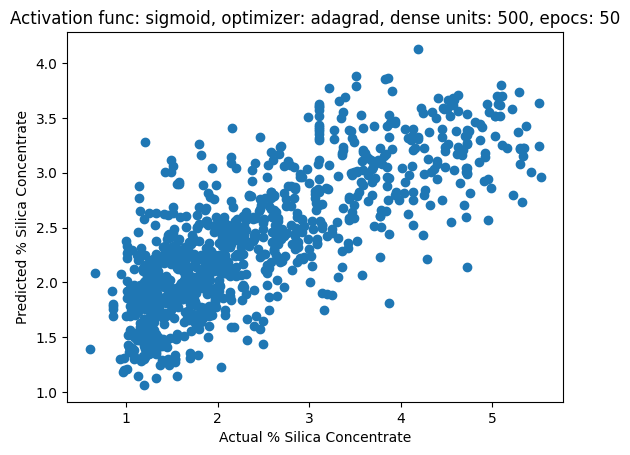

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 500)               11500     
                                                                 
 dense_9 (Dense)             (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 2ms/step - loss: 0.5887 - root_mean_squared_error: 0.7673 - mean_absolute_error: 0.5956 - accuracy: 0.0000e+00


In [35]:
exp4 = Experiment()
exp4.activation='sigmoid'
exp4.optimizer='adagrad'

# ------------------- #
exp4.ann_model = build_ann(exp4)
exp4.ann_history, exp4.ann_prediction = fit_and_predict(exp4, exp4.ann_model)
plot_prediction(exp4, exp4.ann_prediction)

exp4.ann_model.summary(),
exp4.ann_model.evaluate(X, Y)

plot_metrics(exp4.ann_history)

32/32 [==============================] - 0s 4ms/step


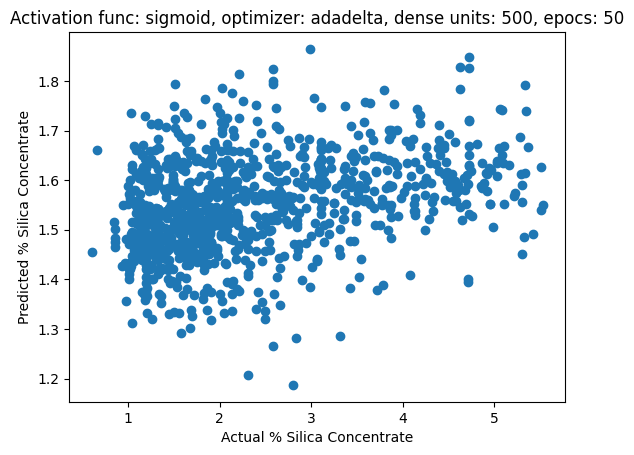

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 500)               11500     
                                                                 
 dense_11 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 1.8797 - root_mean_squared_error: 1.3710 - mean_absolute_error: 0.9646 - accuracy: 0.0000e+00


In [36]:
exp5 = Experiment()
exp5.activation='sigmoid'
exp5.optimizer='adadelta'

# ------------------- #
exp5.ann_model = build_ann(exp5)
exp5.ann_history, exp5.ann_prediction = fit_and_predict(exp5, exp5.ann_model)
plot_prediction(exp5, exp5.ann_prediction)

exp5.ann_model.summary(),
exp5.ann_model.evaluate(X, Y)

plot_metrics(exp5.ann_history)

32/32 [==============================] - 0s 2ms/step


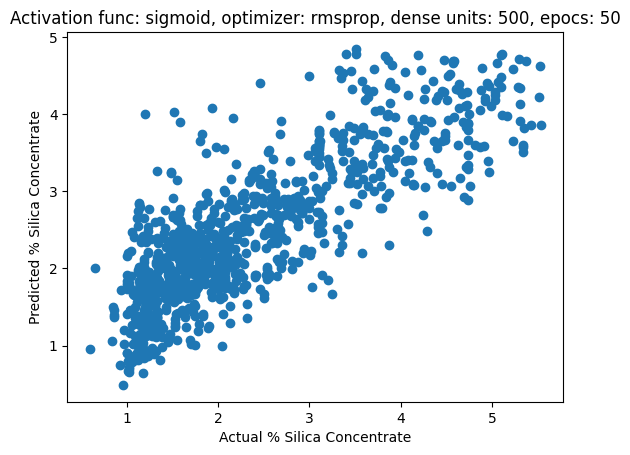

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               11500     
                                                                 
 dense_13 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 5ms/step - loss: 0.4291 - root_mean_squared_error: 0.6550 - mean_absolute_error: 0.5072 - accuracy: 0.0000e+00


In [37]:
exp6 = Experiment()
exp6.activation='sigmoid'
exp6.optimizer='rmsprop'

# ------------------- #
exp6.ann_model = build_ann(exp6)
exp6.ann_history, exp6.ann_prediction = fit_and_predict(exp6, exp6.ann_model)
plot_prediction(exp6, exp6.ann_prediction)

exp6.ann_model.summary(),
exp6.ann_model.evaluate(X, Y)

plot_metrics(exp6.ann_history)

32/32 [==============================] - 0s 2ms/step


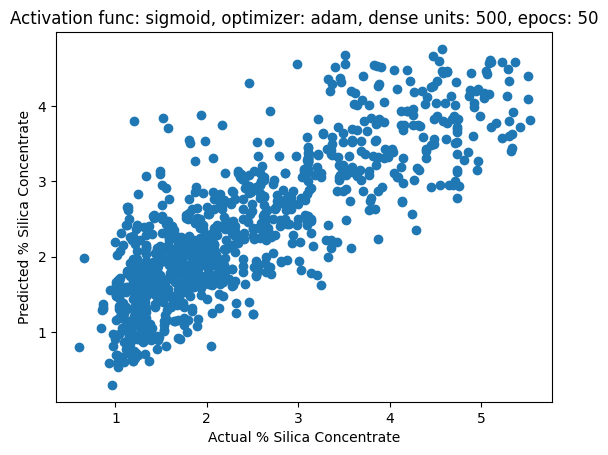

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 500)               11500     
                                                                 
 dense_15 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 2ms/step - loss: 0.4126 - root_mean_squared_error: 0.6424 - mean_absolute_error: 0.4896 - accuracy: 0.0000e+00


In [38]:
exp7 = Experiment()
exp7.activation='sigmoid'
exp7.optimizer='adam'

# ------------------- #
exp7.ann_model = build_ann(exp7)
exp7.ann_history, exp7.ann_prediction = fit_and_predict(exp7, exp7.ann_model)
plot_prediction(exp7, exp7.ann_prediction)

exp7.ann_model.summary(),
exp7.ann_model.evaluate(X, Y)

plot_metrics(exp7.ann_history)

32/32 [==============================] - 0s 3ms/step


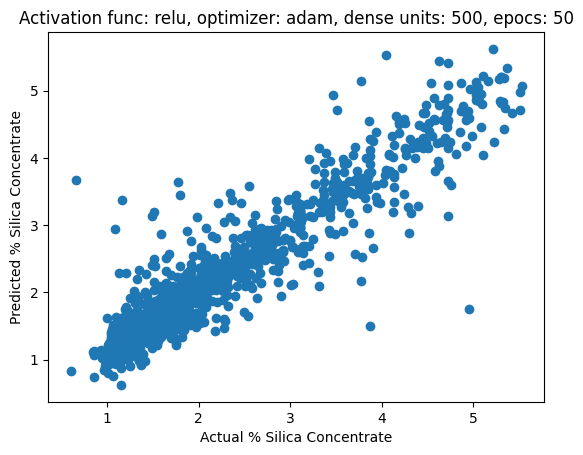

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 500)               11500     
                                                                 
 dense_17 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 4ms/step - loss: 0.1786 - root_mean_squared_error: 0.4226 - mean_absolute_error: 0.2783 - accuracy: 0.0000e+00


In [39]:
exp8 = Experiment()
exp8.activation='relu'
exp8.optimizer='adam'

# ------------------- #
exp8.ann_model = build_ann(exp8)
exp8.ann_history, exp8.ann_prediction = fit_and_predict(exp8, exp8.ann_model)
plot_prediction(exp8, exp8.ann_prediction)

exp8.ann_model.summary(),
exp8.ann_model.evaluate(X, Y)

plot_metrics(exp8.ann_history)

32/32 [==============================] - 0s 3ms/step


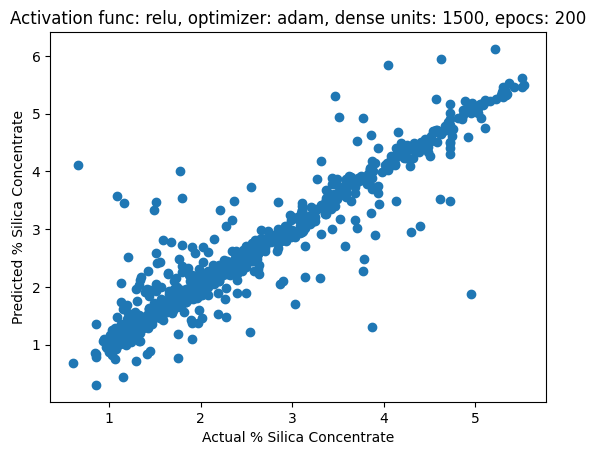

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1500)              34500     
                                                                 
 dense_6 (Dense)             (None, 1)                 1501      
                                                                 
Total params: 36001 (140.63 KB)
Trainable params: 36001 (140.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 2ms/step - loss: 0.1376 - root_mean_squared_error: 0.3709 - mean_absolute_error: 0.1837 - accuracy: 0.0000e+00


In [32]:
exp9 = Experiment()
exp9.activation='relu'
exp9.optimizer='adam'
exp9.epocs=200
exp9.dense_units=1500

# ------------------- #
exp9.ann_model = build_ann(exp9)
exp9.ann_history, exp9.ann_prediction = fit_and_predict(exp9, exp9.ann_model)
plot_prediction(exp9, exp9.ann_prediction)

exp9.ann_model.summary(),
exp9.ann_model.evaluate(X, Y)

plot_metrics(exp9.ann_history)

In [18]:
keras.activations.relu(X, max_value=5.)

<tf.Tensor: shape=(1000, 22), dtype=float64, numpy=
array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])>

In [33]:
custom_adam = keras.optimizers.Adam(
    learning_rate=0.0005, # half the learning rate, default is 0.001
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
)

32/32 [==============================] - 0s 4ms/step


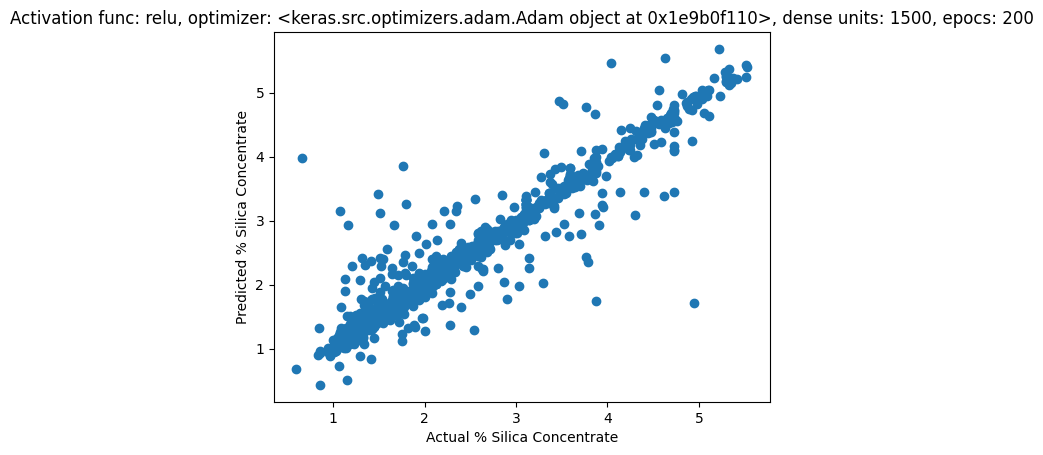

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1500)              34500     
                                                                 
 dense_8 (Dense)             (None, 1)                 1501      
                                                                 
Total params: 36001 (140.63 KB)
Trainable params: 36001 (140.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.1208 - root_mean_squared_error: 0.3476 - mean_absolute_error: 0.1727 - accuracy: 0.0000e+00


In [34]:
exp9 = Experiment()
exp9.activation='relu'
exp9.optimizer=custom_adam
exp9.epocs=200
exp9.dense_units=1500

# ------------------- #
exp9.ann_model = build_ann(exp9)
exp9.ann_history, exp9.ann_prediction = fit_and_predict(exp9, exp9.ann_model)
plot_prediction(exp9, exp9.ann_prediction)

exp9.ann_model.summary(),
exp9.ann_model.evaluate(X, Y)

plot_metrics(exp9.ann_history)

## Recurring Neural Networks

Recurrent neural networks (RNNs) are a class of artificial neural networks for sequential data processing. Unlike feedforward neural networks, which process data in a single pass, RNNs process data across multiple time steps, making them well-adapted for modelling and processing text, speech, and time series.

Implementation based on: https://keras.io/api/layers/recurrent_layers/lstm/

In [41]:
def build_rnn(exp):
    rnn = Sequential()
    # Long Short-Term Memory layer
    rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (exp.x.shape[1], 1)))
    rnn.add(Dropout(0.2))
    
    rnn.add(LSTM(units = 45, return_sequences = True))
    rnn.add(Dropout(0.2))
    
    rnn.add(LSTM(units = 45, return_sequences = True))
    rnn.add(Dropout(0.2))
    
    rnn.add(LSTM(units = 45))
    rnn.add(Dropout(0.2))
    
    rnn.add(Dense(units = 1))
    
    rnn.compile(optimizer = exp.optimizer, 
                loss = exp.loss,
                metrics=[keras.metrics.RootMeanSquaredError(), 
                         keras.metrics.MeanAbsoluteError(),
                         keras.metrics.Accuracy()])
    return rnn

32/32 [==============================] - 3s 24ms/step


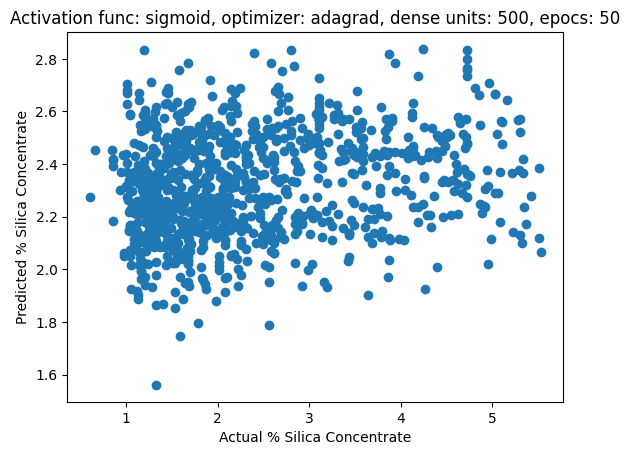

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 45)            8460      
                                                                 
 dropout (Dropout)           (None, 22, 45)            0         
                                                                 
 lstm_1 (LSTM)               (None, 22, 45)            16380     
                                                                 
 dropout_1 (Dropout)         (None, 22, 45)            0         
                                                                 
 lstm_2 (LSTM)               (None, 22, 45)            16380     
                                                                 
 dropout_2 (Dropout)         (None, 22, 45)            0         
                                                                 
 lstm_3 (LSTM)               (None, 45)              

In [42]:
#history = rnn.fit(X, Y, epochs = 100, validation_split=0.2, batch_size = 32)

exp1.rnn_model = build_rnn(exp1)

# ------------------- #
exp1.rnn_history, exp1.rnn_prediction = fit_and_predict(exp1, exp1.rnn_model)
plot_prediction(exp1, exp1.rnn_prediction)

exp1.rnn_model.summary(),
exp1.rnn_model.evaluate(X, Y)

plot_metrics(exp1.rnn_history)

32/32 [==============================] - 3s 22ms/step


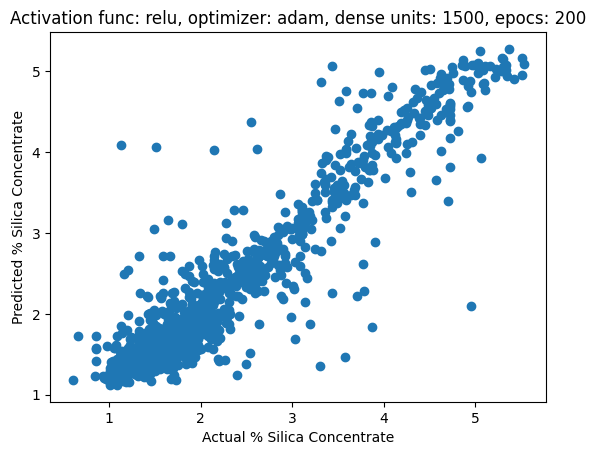

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 22, 45)            8460      
                                                                 
 dropout_4 (Dropout)         (None, 22, 45)            0         
                                                                 
 lstm_5 (LSTM)               (None, 22, 45)            16380     
                                                                 
 dropout_5 (Dropout)         (None, 22, 45)            0         
                                                                 
 lstm_6 (LSTM)               (None, 22, 45)            16380     
                                                                 
 dropout_6 (Dropout)         (None, 22, 45)            0         
                                                                 
 lstm_7 (LSTM)               (None, 45)              

In [43]:
exp9.rnn_model = build_rnn(exp9)

# ------------------- #
exp9.rnn_history, exp9.rnn_prediction = fit_and_predict(exp9, exp9.rnn_model)
plot_prediction(exp9, exp9.rnn_prediction)

exp9.rnn_model.summary()
exp9.rnn_model.evaluate(X, Y)

plot_metrics(exp9.rnn_history)

## ANN vs RNN metrics side by side comparison

This section aims to compare experiment 9 for ANN vs RNN (`relu` + `adam`)

In [44]:
print("ANN")
plot_metrics(exp9.ann_history)
print("RNN")
plot_metrics(exp9.rnn_history)

ANN


RNN


## Experiment with MinMax Scaler

In [45]:
ms_scaler = MinMaxScaler()
X_ms_scaled = ms_scaler.fit_transform(X)

32/32 [==============================] - 0s 1ms/step


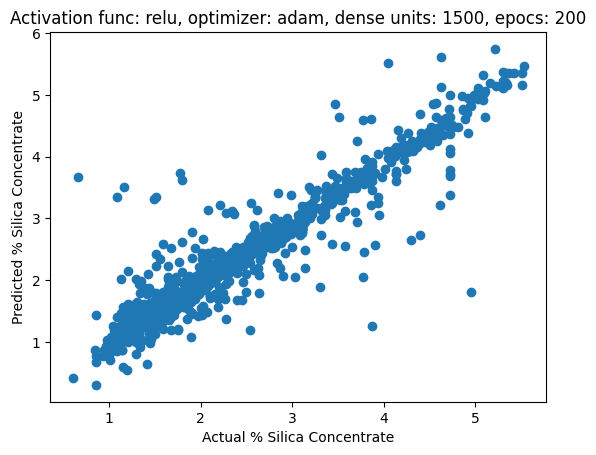

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1500)              34500     
                                                                 
 dense_23 (Dense)            (None, 1)                 1501      
                                                                 
Total params: 36001 (140.63 KB)
Trainable params: 36001 (140.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.1420 - root_mean_squared_error: 0.3768 - mean_absolute_error: 0.2107 - accuracy: 0.0000e+00


In [46]:
exp10 = Experiment()

exp10.activation='relu'
exp10.optimizer='adam'
exp10.epocs=200
exp10.dense_units=1500

exp10.X = X_ms_scaled


# ------------------- #
exp10.ann_model = build_ann(exp10)
exp10.ann_history, exp10.ann_prediction = fit_and_predict(exp10, exp10.ann_model)
plot_prediction(exp10, exp10.ann_prediction)

exp10.ann_model.summary(),
exp10.ann_model.evaluate(X, Y)

plot_metrics(exp10.ann_history)

32/32 [==============================] - 2s 19ms/step


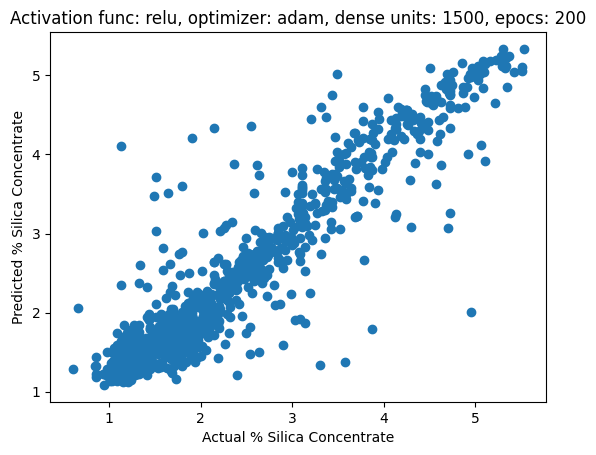

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 22, 45)            8460      
                                                                 
 dropout_8 (Dropout)         (None, 22, 45)            0         
                                                                 
 lstm_9 (LSTM)               (None, 22, 45)            16380     
                                                                 
 dropout_9 (Dropout)         (None, 22, 45)            0         
                                                                 
 lstm_10 (LSTM)              (None, 22, 45)            16380     
                                                                 
 dropout_10 (Dropout)        (None, 22, 45)            0         
                                                                 
 lstm_11 (LSTM)              (None, 45)              

In [47]:
exp10.rnn_model = build_rnn(exp10)

# ------------------- #
exp10.rnn_history, exp10.rnn_prediction = fit_and_predict(exp10, exp10.rnn_model)
plot_prediction(exp10, exp10.rnn_prediction)

exp10.rnn_model.summary()
exp10.rnn_model.evaluate(X, Y)

plot_metrics(exp10.rnn_history)

Plotting the difference between ANN for experiment 9 (Standard scaler) and expriment 10 (MinMax scaler)

In [48]:
print("ANN on StandardScaler")
plot_metrics(exp9.ann_history)
print("ANN on MinMaxScaler")
plot_metrics(exp10.ann_history)

ANN on StandardScaler


ANN on MinMaxScaler


24/09/16 04:37:28 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2874677 ms exceeds timeout 120000 ms
24/09/16 04:37:28 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/16 04:37:28 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$